# 📉 Spectral Analysis of Random Matrices: Wigner's Semicircle Law

**Notebook Update (2026):** Yacine  
**Original Project (2024):** Yacine, Octave & Roman  
**Affiliation:** Dual Degree Candidate - ENS de Lyon (Physics) & École des Ponts ParisTech (Applied Maths/CS)  
**Documentation:** [**Read the Original 2024 Project Report**](./Project_report.pdf)

---

###  Preface
This notebook, developed in **2026**, revisits and modernizes the code from a physics simulation project originally conducted in **2024** by Yacine, Octave, and Roman.
This noebook only contains a code generating each figure of [**the Original 2024 Project Report**](./Project_report.pdf)

###  Figure 1
The first figure is directly extracted rom the aticle[^1] which we used in 2024 and also cited as source [1] in the report.

### Figure 2
The second figure was created by another member. of the group and I don't have the code for it anymore.

### Imports, configuration and main functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from tqdm import tqdm
import warnings
from scipy.stats import linregress
from joblib import Parallel, delayed  #pour paraleliser dans la figure 6 mais cest facultatif

# Configuration pour des plots haute résolution (Retina display)
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-paper') 
warnings.filterwarnings('ignore')

def generate_gue_matrix(n: int) -> np.ndarray:
    """Generates a Hermitian matrix from the Gaussian Unitary Ensemble."""
    # Complex random matrix
    Z = np.random.randn(n, n) + 1j * np.random.randn(n, n)
    # Hermitisation
    H = (Z + Z.conj().T) / 2
    return H

def wigner_semicircle(x, R):
    """Theoretical PDF."""
    return (2 / (np.pi * R**2)) * np.sqrt(np.maximum(0, R**2 - x**2))


#pour paaraleliser dans la figure 6 (utilisation de joblib)
def compute_single_realization(n, alpha, R, n_bins):
    """
    Cette fonction effectue le travail pour UNE seule matrice.
    Elle sera exécutée par les différents cœurs du CPU.
    """
    # 1. Génération
    H = generate_gue_matrix(n)
    
    # 2. Diagonalisation (Lourd !)
    evals = linalg.eigvalsh(H) / np.sqrt(n)
    
    # 3. Calcul de l'erreur
    hist, bin_edges = np.histogram(evals, bins=n_bins, range=(-R, R), density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    theo_vals = wigner_semicircle(bin_centers, R)
    
    error = np.mean((hist - theo_vals)**2)
    return error

### Figure 3
* **Matrix Generation:** Random symmetric matrices of size $n$ **are generated** with Gaussian coefficients (Normal distribution).
* **Spectrum Calculation:** For each matrix, the set of eigenvalues **is calculated**. Since the empirical spectrum is discrete (a "Dirac comb"), it cannot be directly compared to the continuous theoretical curve.
* **Histogram Construction (Smoothing):** To address this, the eigenvalues **are grouped** into histogram bins. An error analysis **determines** that the **optimal bin width is of the order of $1/\sqrt{n}$** (corresponding to a precision $\alpha=1/2$), which **corresponds** to the specific width used for Figure 3.
* **Comparison:** The resulting histogram **is overlaid** with the theoretical semicircle probability density function to visualize the convergence.

Calcul en cours...


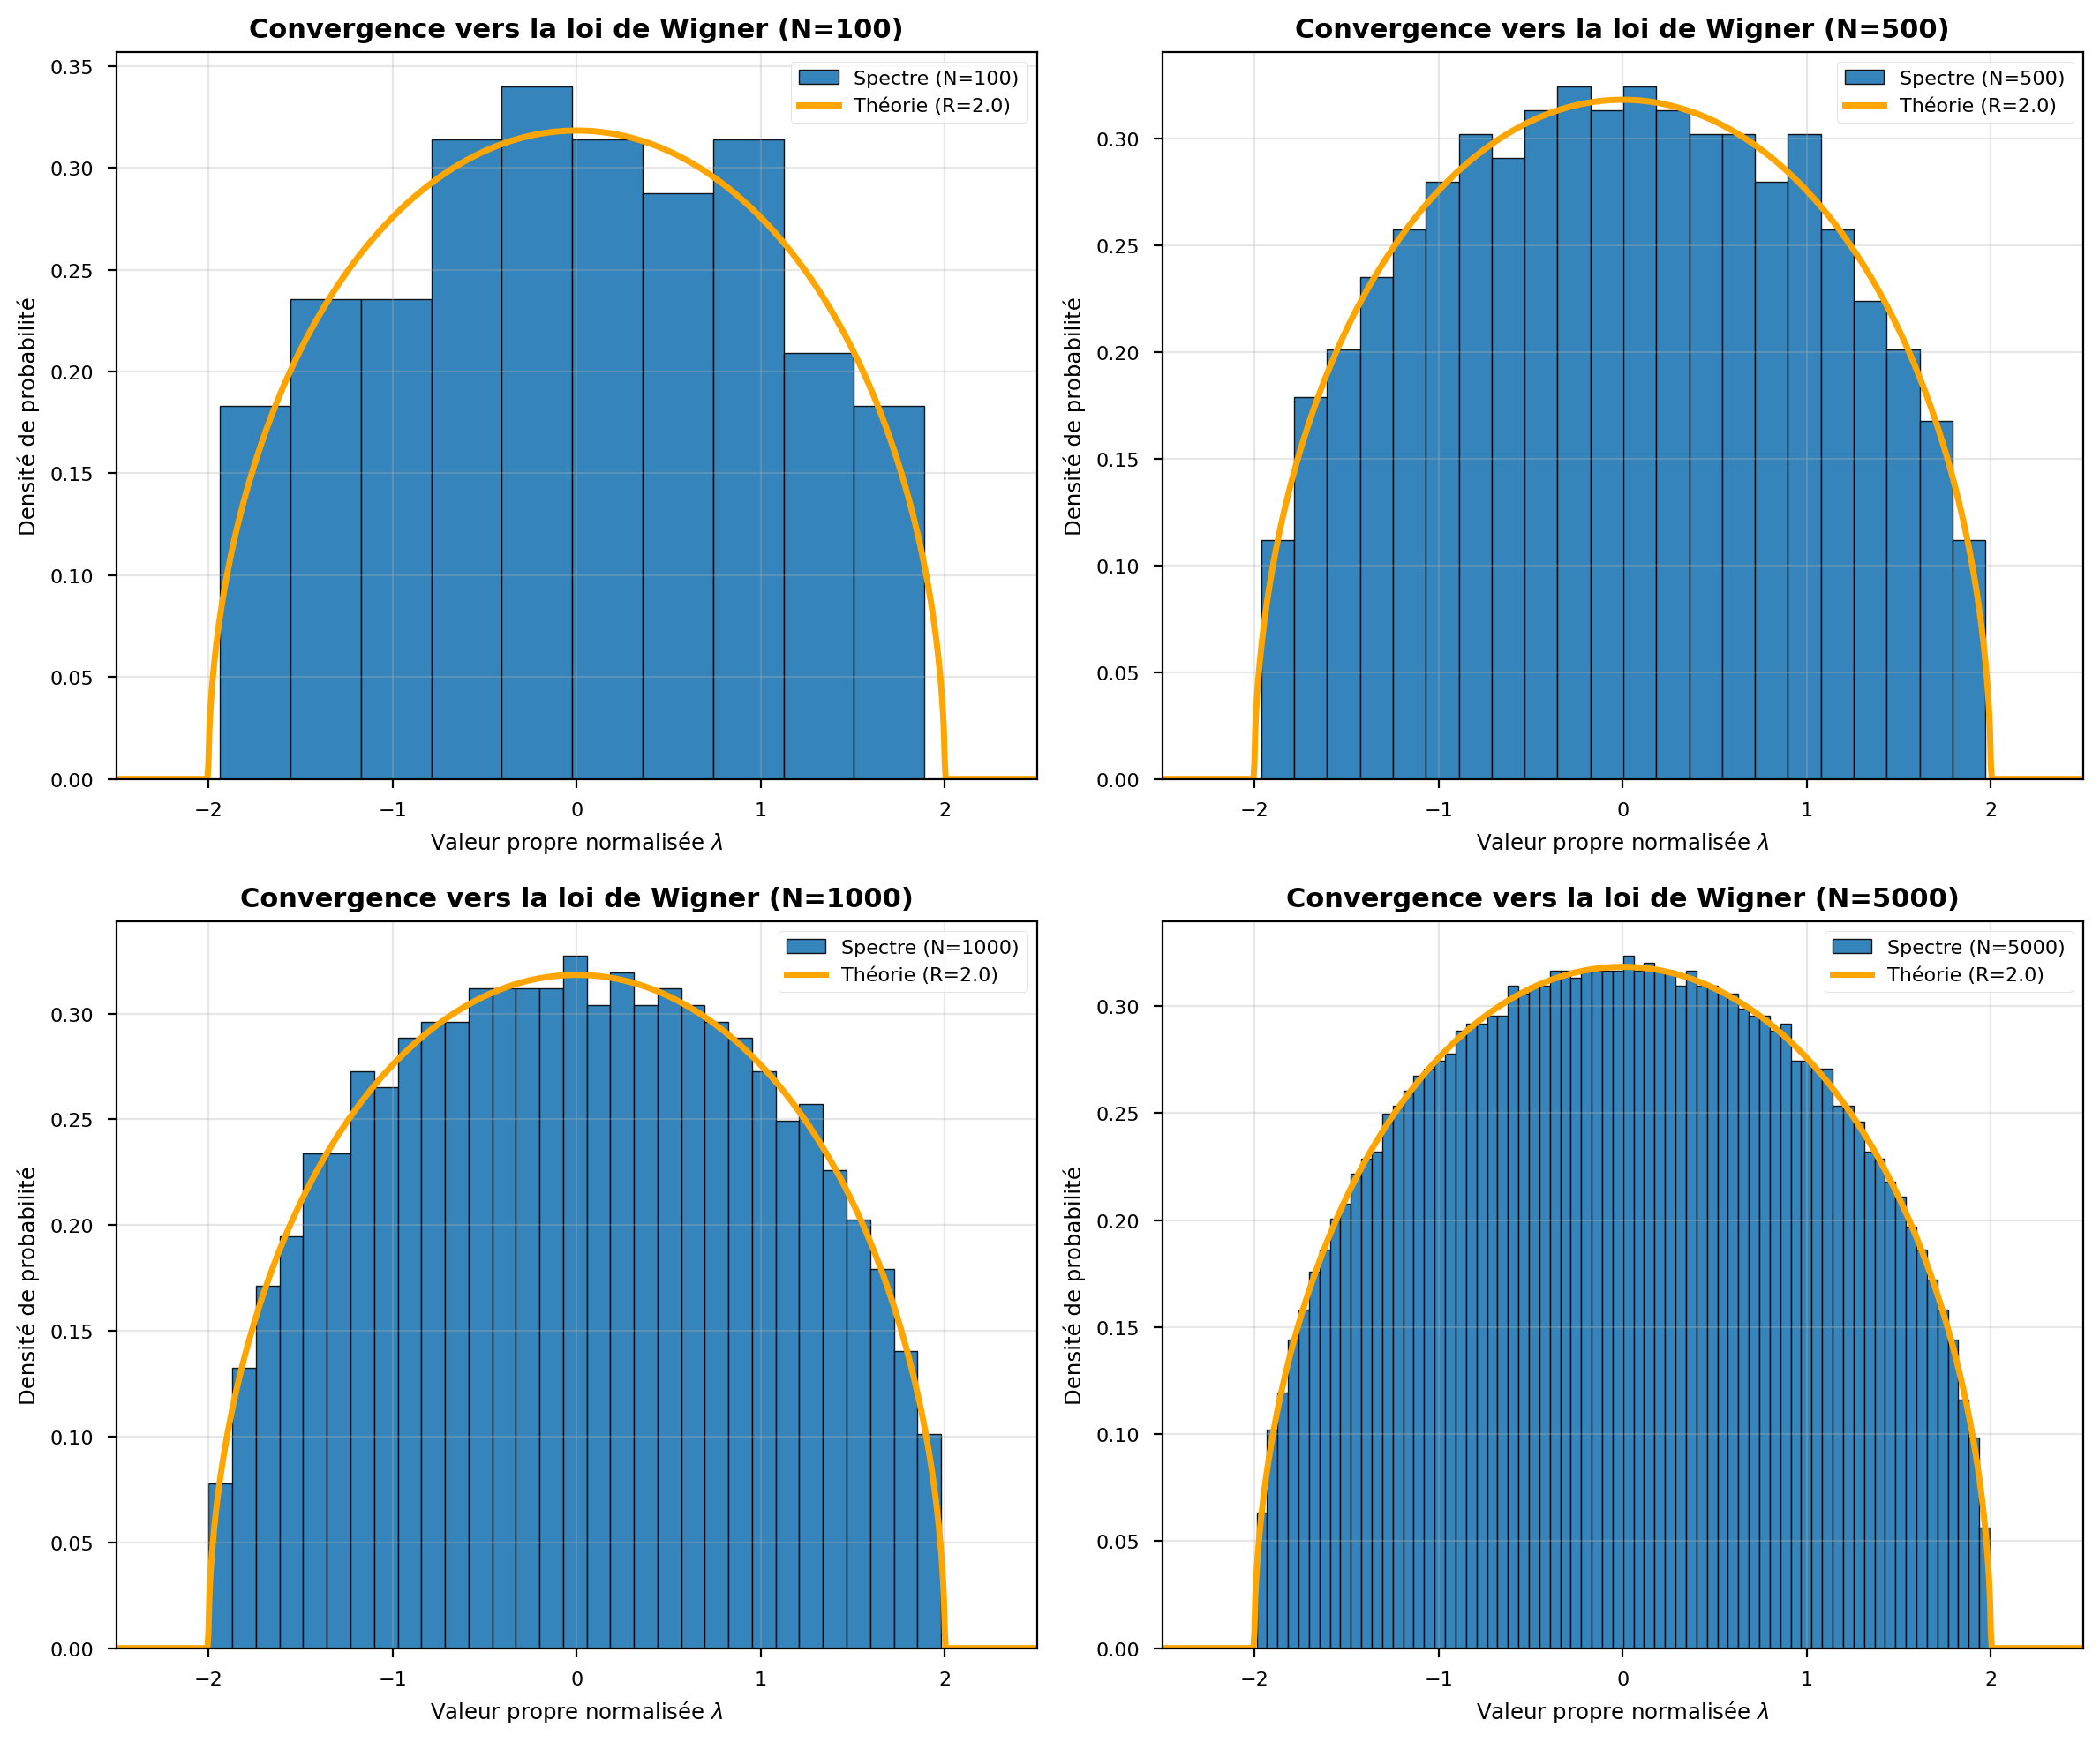

In [2]:
SIGMA = 1.0
RAYON_SPECTRAL = 2.0 * SIGMA
LISTE_N = [100, 500, 1000, 5000]

MARGE_VISUELLE = 0.5
X_MIN = -RAYON_SPECTRAL - MARGE_VISUELLE
X_MAX = RAYON_SPECTRAL + MARGE_VISUELLE
NB_POINTS_COURBE = 1000

def generate_gue_matrix(n: int) -> np.ndarray:
    Z = np.random.randn(n, n) + 1j * np.random.randn(n, n)
    H = (Z + Z.conj().T) / 2  # Enforce Hermitian symmetry
    return H

def wigner_pdf(x, R):
    # Safe sqrt for values outside [-R, R]
    return (2 / (np.pi * R**2)) * np.sqrt(np.maximum(0, R**2 - x**2))

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

print("Calcul en cours...")

for i, N in enumerate(LISTE_N):
    ax = axes[i]
    
    H = generate_gue_matrix(N)
    valeurs_propres = np.linalg.eigvalsh(H)
    
    valeurs_propres_norm = valeurs_propres / np.sqrt(N)  # Rescale spectrum
    
    nb_bins = int(np.sqrt(N))  # Optimal bin count
    
    ax.hist(valeurs_propres_norm, bins=nb_bins, density=True, 
            edgecolor='black', linewidth=0.5, alpha=0.9, 
            label=f'Spectre (N={N})')
    
    x_plot = np.linspace(X_MIN, X_MAX, NB_POINTS_COURBE)
    y_plot = wigner_pdf(x_plot, R=RAYON_SPECTRAL)
    
    ax.plot(x_plot, y_plot, color='orange', linewidth=2.5, 
            label=f'Théorie (R={RAYON_SPECTRAL})')
    
    ax.set_title(f"Convergence vers la loi de Wigner (N={N})", fontsize=11, fontweight='bold')
    ax.set_xlabel("Valeur propre normalisée $\lambda$")
    ax.set_ylabel("Densité de probabilité")
    ax.set_xlim(X_MIN, X_MAX)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()  

### Figure 4

Génération des matrices et calcul des spectres pour N=5000...
  - Distribution Uniforme...
  - Distribution de Poisson...
Tracé des résultats...


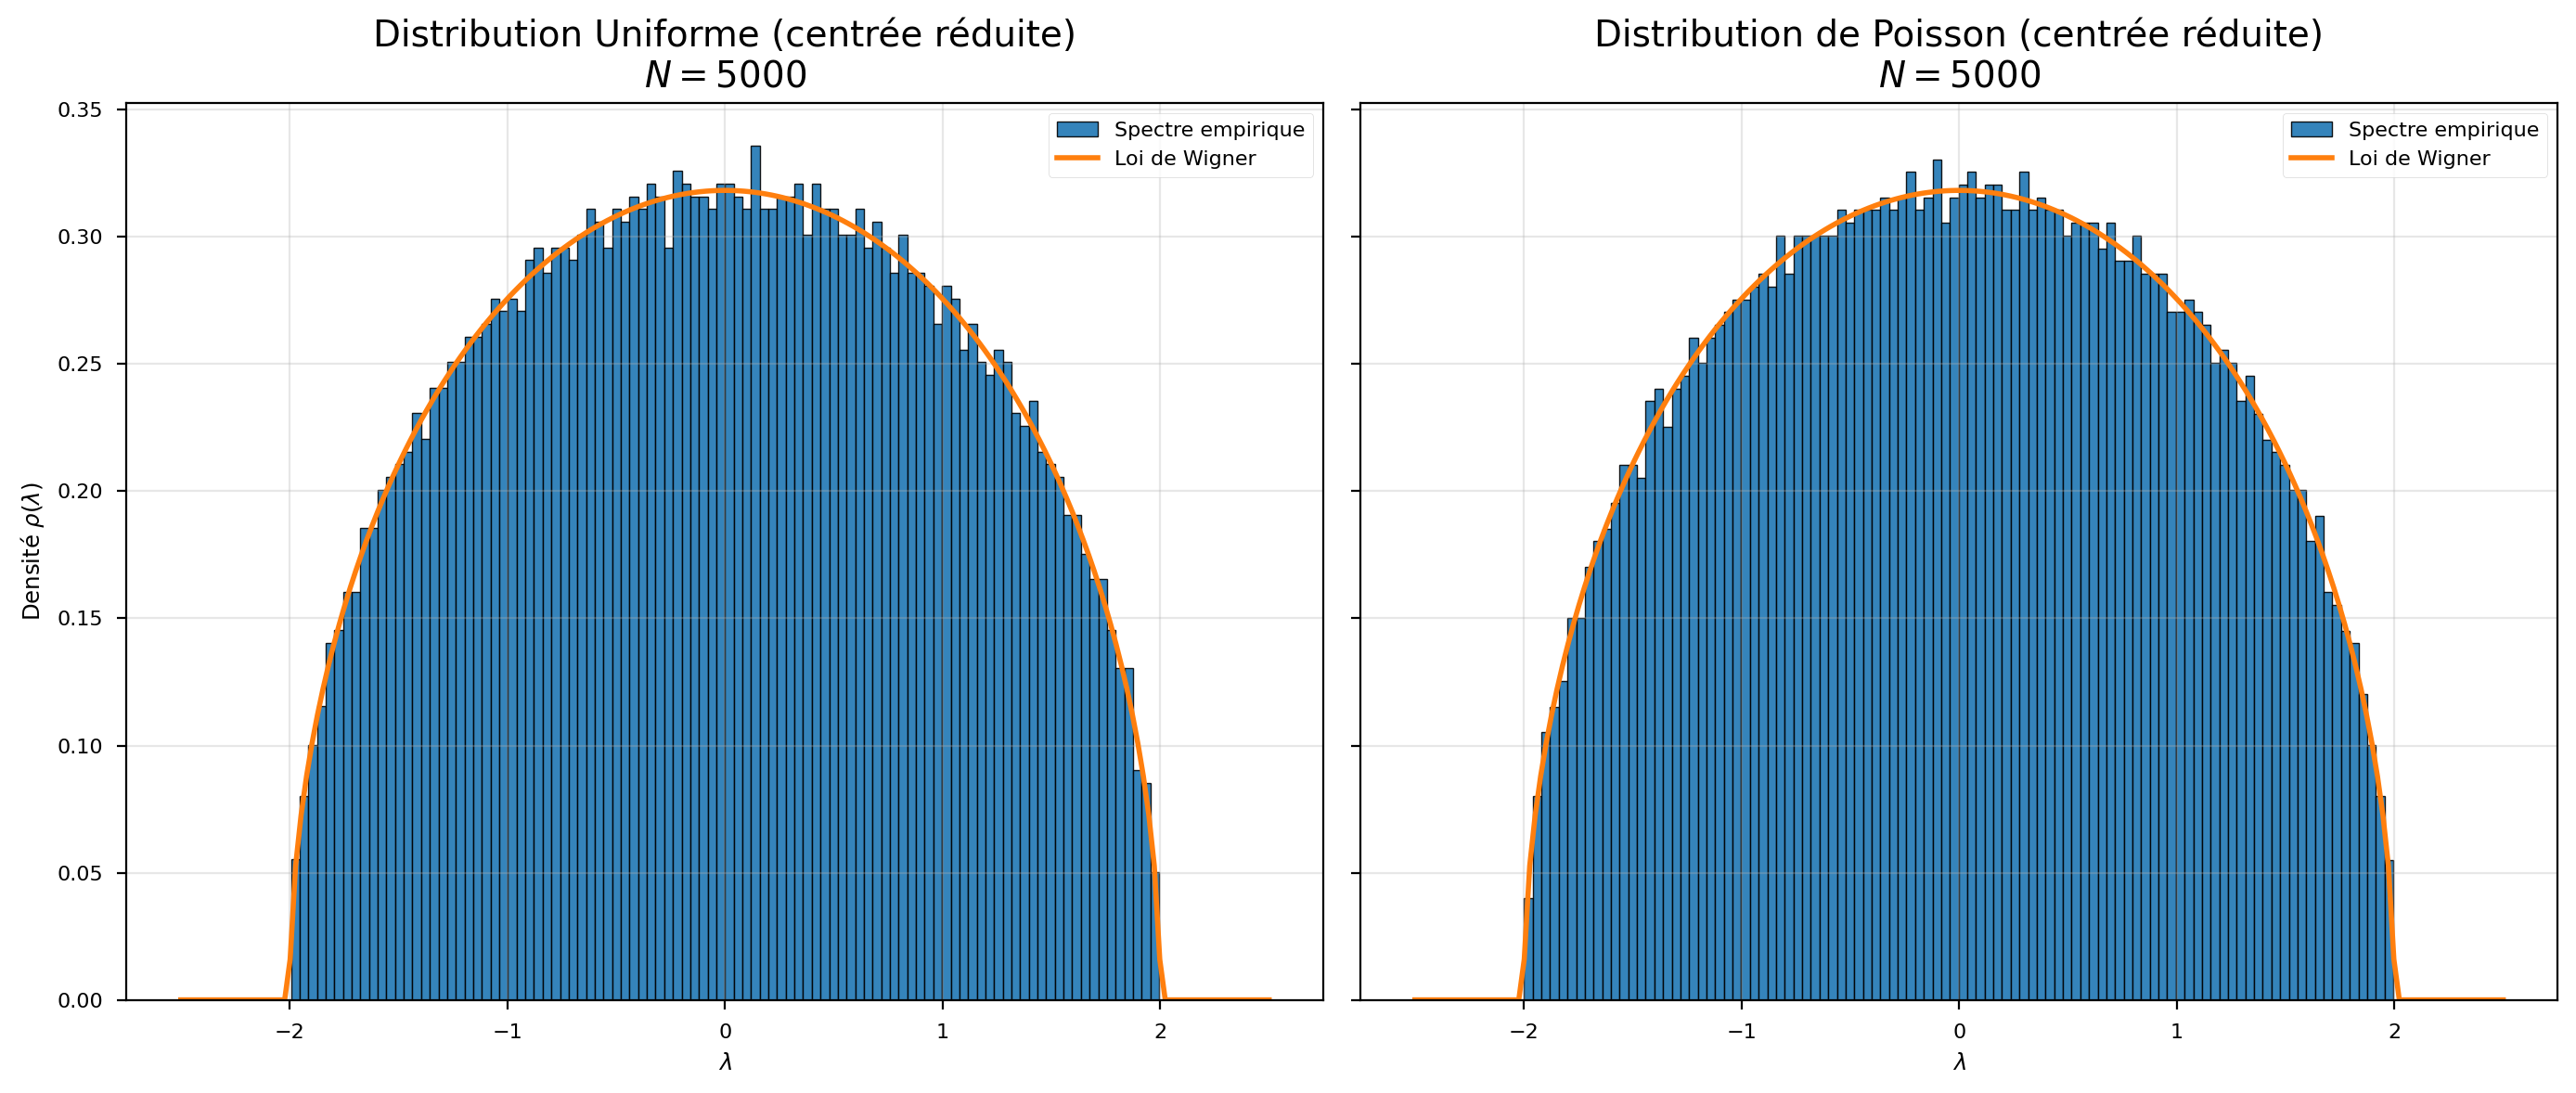

In [3]:
# --- Paramètres de la simulation ---
N = 5000  # Dimension des matrices (comme indiqué dans le rapport)
bins = 100 # Nombre de classes pour l'histogramme
R = 2     # Rayon du demi-cercle (pour variance normalisée à 1)



def generate_wigner_uniform(n: int) -> np.ndarray:
    """
    Génère une matrice de Wigner avec coefficients issus d'une loi Uniforme.
    Loi U[-sqrt(3), sqrt(3)] pour avoir une moyenne nulle et une variance de 1.
    """
    limit = np.sqrt(3)
    M = np.random.uniform(-limit, limit, (n, n))
    M = np.triu(M) + np.triu(M, 1).T
    return M / np.sqrt(n)

def generate_wigner_poisson(n: int, lam: float = 1.0) -> np.ndarray:
    """
    Génère une matrice de Wigner avec coefficients issus d'une loi de Poisson.
    Centrée (X - lambda) et réduite (/ sqrt(lambda)).
    """
    M = np.random.poisson(lam, (n, n)).astype(float)
    M = (M - lam) / np.sqrt(lam)
    M = np.triu(M) + np.triu(M, 1).T
    return M / np.sqrt(n)

# --- Calcul des spectres ---
print(f"Génération des matrices et calcul des spectres pour N={N}...")
print("  - Distribution Uniforme...")
H_uni = generate_wigner_uniform(N)
eig_uni = np.linalg.eigvalsh(H_uni)
print("  - Distribution de Poisson...")
H_pois = generate_wigner_poisson(N, lam=4) # lambda=4 pour avoir une distribution assez "lisse" mais discrète à la base
eig_pois = np.linalg.eigvalsh(H_pois)

print("Tracé des résultats...")
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
x = np.linspace(-R-0.5, R+0.5, 200)
y_theo = wigner_semicircle(x, R)

# Plot 1: Uniforme
axes[0].hist(eig_uni, bins=bins, density=True, edgecolor='black', linewidth=0.5, alpha=0.9, label='Spectre empirique')
axes[0].plot(x, y_theo, linewidth=2, label='Loi de Wigner')
axes[0].set_title(f'Distribution Uniforme (centrée réduite)\n$N={N}$', fontsize=14)
axes[0].set_xlabel('$\lambda$')
axes[0].set_ylabel('Densité $\\rho(\lambda)$')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Poisson
axes[1].hist(eig_pois, bins=bins, density=True, edgecolor='black', linewidth=0.5, alpha=0.9, label='Spectre empirique')
axes[1].plot(x, y_theo, linewidth=2, label='Loi de Wigner')
axes[1].set_title(f'Distribution de Poisson (centrée réduite)\n$N={N}$', fontsize=14)
axes[1].set_xlabel('$\lambda$')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Figure 5

Reproduction de la Figure 5 : Optimisation de alpha (n=500, K=50)...


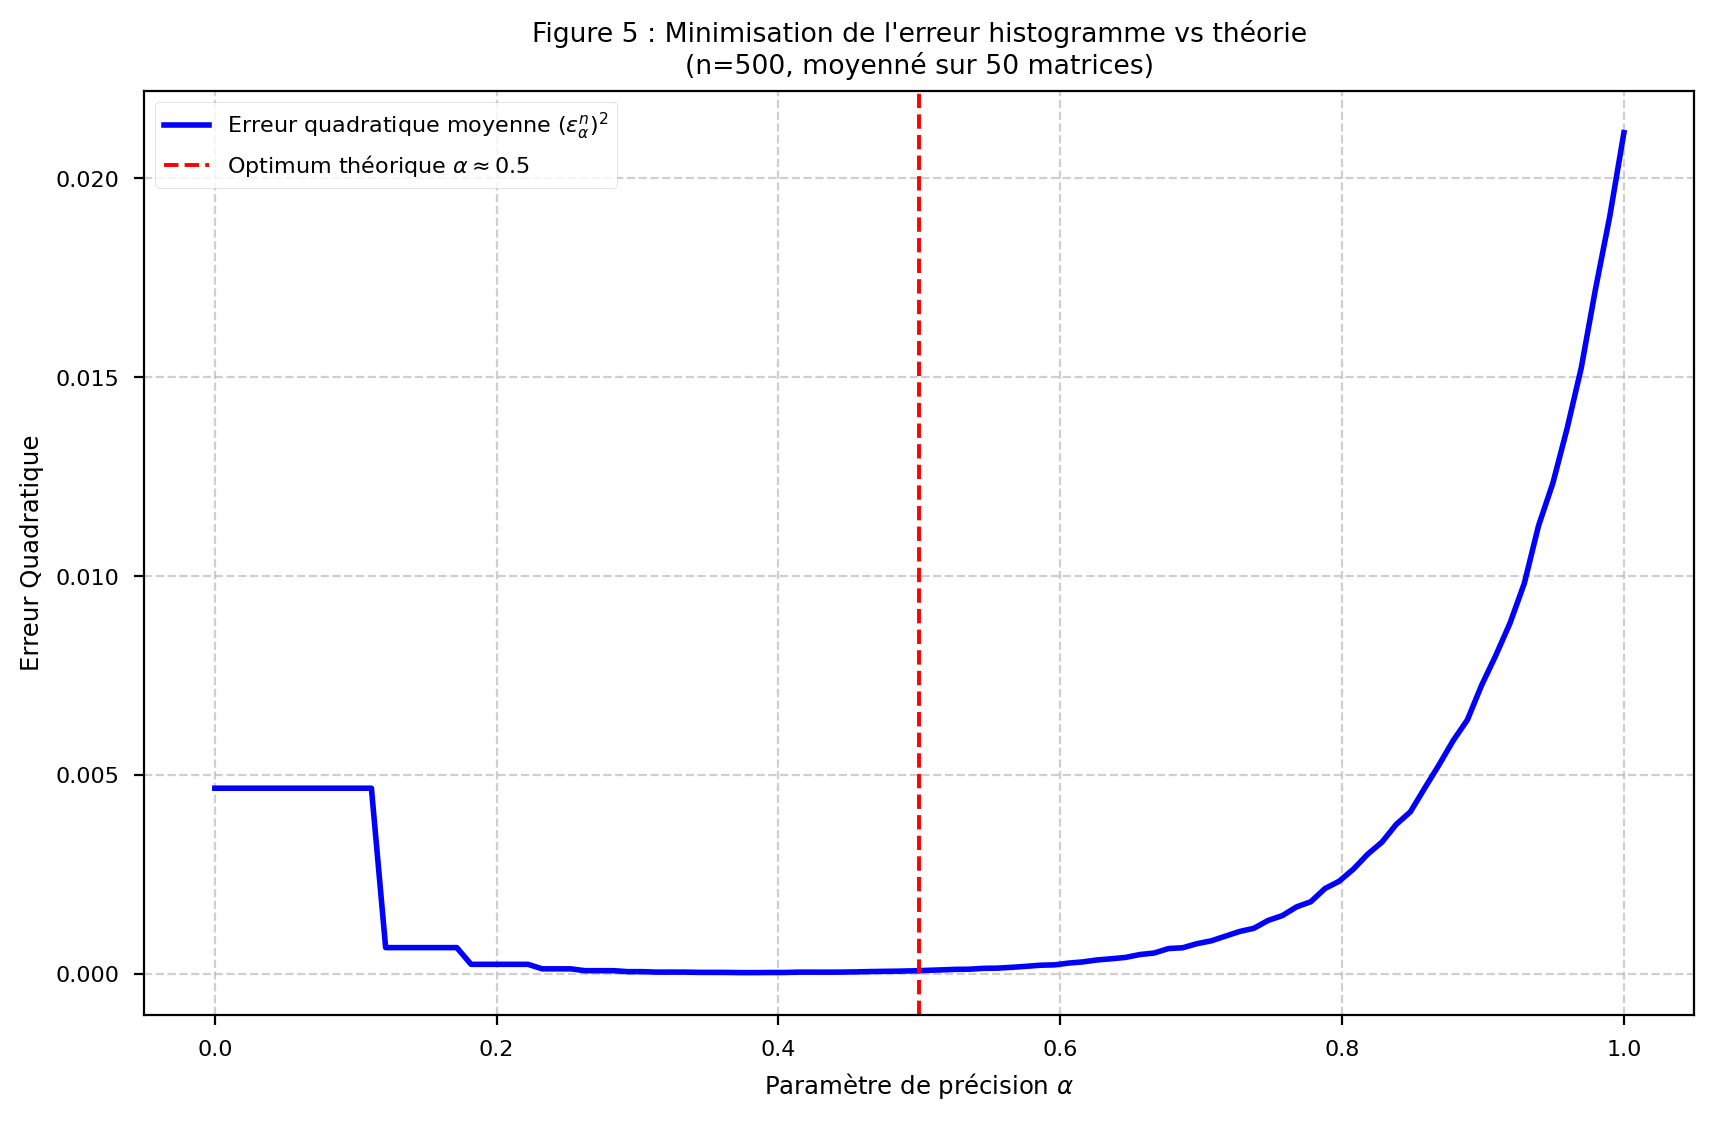

In [4]:
n = 500
K = 50
n_alphas = 100
alphas = np.linspace(0, 1, n_alphas)
R = 2.0

print(f"Reproduction de la Figure 5 : Optimisation de alpha (n={n}, K={K})...")

all_eigenvalues = []
for _ in range(K):
    H = generate_gue_matrix(n)
    evals = linalg.eigvalsh(H) / np.sqrt(n)
    all_eigenvalues.append(evals)

mean_errors = []

for alpha in alphas:
    current_alpha_error = 0
    n_bins = int(n**alpha)
    n_bins = max(1, n_bins)

    for evals in all_eigenvalues:
        hist, bin_edges = np.histogram(evals, bins=n_bins, range=(-R, R), density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        theo_vals = wigner_semicircle(bin_centers, R)
        
        error = np.mean((hist - theo_vals)**2)
        current_alpha_error += error

    mean_errors.append(current_alpha_error / K)

plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_errors, label=r'Erreur quadratique moyenne $(\epsilon_{\alpha}^n)^2$', color='blue', linewidth=2)
plt.xlabel(r'Paramètre de précision $\alpha$')
plt.ylabel('Erreur Quadratique')
plt.title(f'Figure 5 : Minimisation de l\'erreur histogramme vs théorie\n(n={n}, moyenné sur {K} matrices)')
plt.axvline(0.5, color='red', linestyle='--', label=r'Optimum théorique $\alpha \approx 0.5$')
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.legend()
plt.show()

### Figure 6 avec calcul paralellisé 
(demande beauscoup de ram)

Génération de la Figure 6 parallélisée sur Mac M4 (50 points)...


 90%|█████████ | 45/50 [3:19:44<1:22:43, 992.80s/it]Python(17745) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17746) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(17747) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
 92%|█████████▏| 46/50 [3:40:27<1:11:11, 1067.76s/it]Python(18985) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18986) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18987) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(18988) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
 94%|█████████▍| 47/50 [4:01:45<56:32, 1130.86s/it]  Python(19593) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(19594) MallocStackLogging: can't turn off malloc st

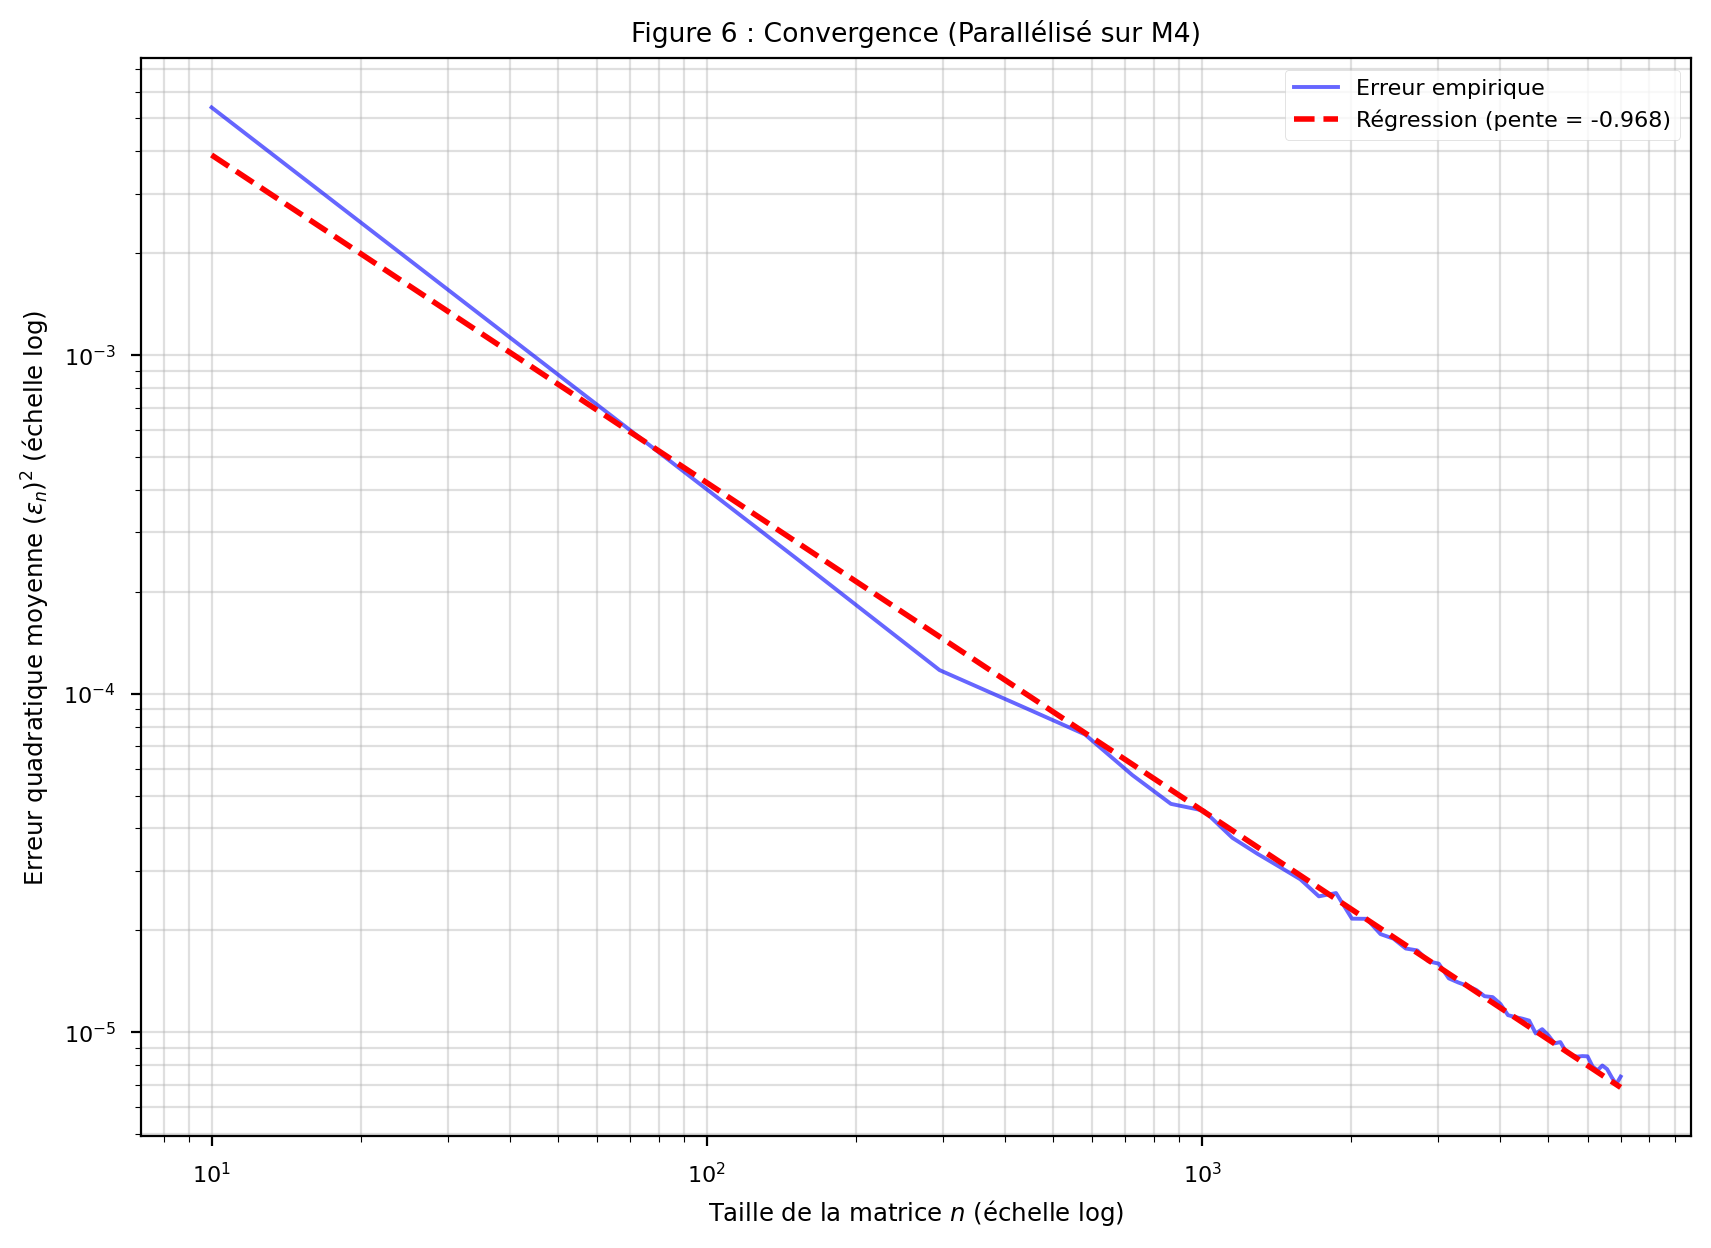

Pente calculée : -0.9680


In [5]:
n_values = np.unique(np.linspace(10, 7000, 50).astype(int))
K = 50
alpha = 0.5
R = 2.0

mean_squared_errors = []

print(f"Génération de la Figure 6 parallélisée sur Mac M4 ({len(n_values)} points)...")


for n in tqdm(n_values):
    
    n_bins = int(n**alpha)
    n_bins = max(5, n_bins)

    # --- PARTIE PARALLÉLISÉE ---
    current_n_errors = Parallel(n_jobs=-1)(
        delayed(compute_single_realization)(n, alpha, R, n_bins) 
        for _ in range(K)
    )
    mean_squared_errors.append(np.mean(current_n_errors))

log_n = np.log(n_values)
log_mse = np.log(mean_squared_errors)

slope, intercept, r_value, p_value, std_err = linregress(log_n, log_mse)

plt.figure(figsize=(10, 7))
plt.loglog(n_values, mean_squared_errors, markersize=4, label='Erreur empirique', alpha=0.6, color='blue')
y_fit = np.exp(intercept) * n_values**slope
plt.loglog(n_values, y_fit, 'r--', label=f'Régression (pente = {slope:.3f})', linewidth=2)

plt.xlabel(r'Taille de la matrice $n$ (échelle log)')
plt.ylabel(r'Erreur quadratique moyenne $(\epsilon_n)^2$ (échelle log)')
plt.title(f'Figure 6 : Convergence (Parallélisé sur M4)')
plt.grid(True, which="both", ls="-", alpha=0.4)
plt.legend()
plt.show()

print(f"Pente calculée : {slope:.4f}")

### Figure 6 avec calcul sur un seul coeur

In [ ]:
n_values = np.unique(np.linspace(10, 7000, 50).astype(int))
K = 50
alpha = 0.5
R = 2.0

mean_squared_errors = []

print(f"Génération de la Figure 6 avec répartition linéaire des n ({len(n_values)} points)...")

for n in tqdm(n_values):
    current_n_errors = []
    
    n_bins = int(n**alpha)
    n_bins = max(5, n_bins)
    
    for _ in range(K):
        H = generate_gue_matrix(n)
        evals = linalg.eigvalsh(H) / np.sqrt(n)
        hist, bin_edges = np.histogram(evals, bins=n_bins, range=(-R, R), density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        theo_vals = wigner_semicircle(bin_centers, R)
        error = np.mean((hist - theo_vals)**2)
        current_n_errors.append(error)
    
    mean_squared_errors.append(np.mean(current_n_errors))

log_n = np.log(n_values)
log_mse = np.log(mean_squared_errors)

slope, intercept, r_value, p_value, std_err = linregress(log_n, log_mse)

plt.figure(figsize=(10, 7))

plt.loglog(n_values, mean_squared_errors, markersize=4, label='Erreur empirique', alpha=0.6, color='blue')

y_fit = np.exp(intercept) * n_values**slope
plt.loglog(n_values, y_fit, 'r--', label=f'Régression (pente = {slope:.3f})', linewidth=2)

plt.xlabel(r'Taille de la matrice $n$ (échelle log)')
plt.ylabel(r'Erreur quadratique moyenne $(\epsilon_n)^2$ (échelle log)')
plt.title(f'Figure 6 : Convergence (Points linéairement espacés)')
plt.grid(True, which="both", ls="-", alpha=0.4)
plt.legend()

plt.show()

print(f"Pente calculée : {slope:.4f}")

Génération de la Figure 6 avec répartition linéaire des n (50 points)...


 32%|███▏      | 16/50 [03:27<18:32, 32.72s/it]